In [1]:
import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc
import anndata

import torch 
from scvi.dataset.dataset import GeneExpressionDataset
from scvi.inference import UnsupervisedTrainer
from scvi.models import SCANVI, VAE
from umap import UMAP

PRJ_DIR = "/home/derek/research/Kim-Lab/normalization-simulation/"
IN_DIR = PRJ_DIR + "data/pbmc-33k/filtered_gene_bc_matrices/hg19/"
OUT_DIR = PRJ_DIR + "exp/exp-12/out/"

/home/derek/miniconda3/envs/py-ds-scanpy-2/lib/python3.8/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [3]:
cm_barcodes = pd.read_csv(IN_DIR + "barcodes.tsv", header=None, sep='\t')
cm_barcodes.rename(columns={0:'barcode'}, inplace=True)
cm_barcodes.set_index('barcode', inplace=True)

In [4]:
cm_ann = sc.read_10x_mtx(IN_DIR, var_names='gene_symbols', cache=True)
cm_ann.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
cm_ann.obs = cm_barcodes
sc.pp.filter_genes(cm_ann, min_cells=5)

In [5]:
from scvi.dataset import AnnDatasetFromAnnData
cm = AnnDatasetFromAnnData(cm_ann)

[2020-07-08 22:28:40,509] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-08 22:28:40,511] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-08 22:28:40,928] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-08 22:28:40,979] INFO - scvi.dataset.dataset | Downsampled from 33148 to 33148 cells


In [8]:
n_epochs = 400
n_de = 4000

In [9]:
cm.subsample_genes(n_de)

[2020-07-08 22:30:13,591] INFO - scvi.dataset.dataset | Not subsampling. Expecting: 1 < (new_n_genes=4000) <= self.nb_genes


In [10]:
use_cuda = True

vae = VAE(cm.nb_genes, n_batch=0, n_labels=0,
          n_hidden=128, n_layers=1, n_latent=10, dispersion='gene')

trainer = UnsupervisedTrainer(
    vae, cm,                               
    train_size=1.0, 
    batch_size=128,
    use_cuda=use_cuda,
    n_epochs_kl_warmup=100,
    frequency=5
)

In [11]:
trainer.train(n_epochs=n_epochs)

[2020-07-08 22:30:40,791] INFO - scvi.inference.inference | KL warmup for 100 epochs


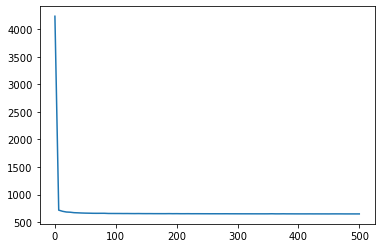

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
elbo_train_set = trainer.history["elbo_train_set"]
x = np.linspace(0, 500, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
# plt.ylim(1150, 1600)

In [20]:
full = trainer.create_posterior(trainer.model, cm, indices=np.arange(len(cm)))
latent, batch_indices, labels = full.sequential().get_latent()

In [28]:
cm_ann.obs.index

Index(['AAACATTGACGACT-1', 'AAACATTGACGGGA-1', 'AAACATTGCCGCTT-1',
       'AAACATTGCTCATT-1', 'AAACCGTGCCCTCA-1', 'AAACCGTGCCTTTA-1',
       'AAACCGTGCGAATC-1', 'AAACGCACTTGTGG-1', 'AAACGCTGCTTAGG-1',
       'AAACGCTGGTGAGG-1',
       ...
       'TTTGACTGATGTCG-6', 'TTTGACTGGAAGGC-6', 'TTTGACTGTCCGTC-6',
       'TTTGCATGAAAACG-6', 'TTTGCATGAAGGGC-6', 'TTTGCATGCACTAG-6',
       'TTTGCATGCCGAAT-6', 'TTTGCATGGAGGTG-6', 'TTTGCATGGATAAG-6',
       'TTTGCATGGGCATT-6'],
      dtype='object', name='barcode', length=33148)

In [31]:
import anndata

post_adata = anndata.AnnData(X=cm.X)
post_adata.obsm["X_scVI"] = latent
post_adata.obs['batch']=batch_indices
post_adata.obs['barcode']=cm_ann.obs.index
post_adata.var['gene_names']=cm.gene_names

In [37]:
sc.pp.neighbors(post_adata, use_rep="X_scVI", n_neighbors=15, metric='minkowski')
sc.tl.umap(post_adata, min_dist=0.3)

/home/derek/miniconda3/envs/py-ds-scanpy-2/lib/python3.8/site-packages/numba/typed_passes.py:292: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../miniconda3/envs/py-ds-scanpy-2/lib/python3.8/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


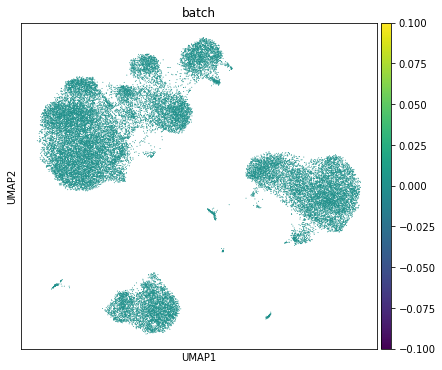

In [39]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["batch"], 
           ax=ax, palette=sc.pl.palettes.vega_20_scanpy)

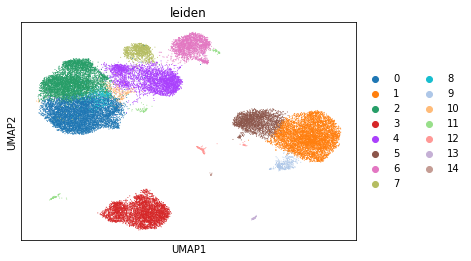

In [40]:
sc.tl.leiden(post_adata, resolution=0.8, key_added='leiden', random_state=10)
sc.pl.umap(post_adata, color=['leiden'],
          palette=sc.pl.palettes.vega_20_scanpy)

In [41]:
post_adata

AnnData object with n_obs × n_vars = 33148 × 4000 
    obs: 'batch', 'barcode', 'leiden'
    var: 'gene_names'
    uns: 'neighbors', 'leiden', 'leiden_colors'
    obsm: 'X_scVI', 'X_umap'

In [53]:
post_adata.obsm['X_umap'][:,0]

array([-5.7744403,  1.3417668,  7.136123 , ...,  4.6739144, -2.2287292,
       -0.7180145], dtype=float32)

In [52]:
post_adata.obs['leiden']

0        2
1        6
2        5
3        4
4        3
        ..
33143    4
33144    7
33145    5
33146    4
33147    4
Name: leiden, Length: 33148, dtype: category
Categories (15, object): [0, 1, 2, 3, ..., 11, 12, 13, 14]

In [58]:
import pandas as pd
res_df = pd.DataFrame({
    'barcode':post_adata.obs['barcode'],
    'umap_x': post_adata.obsm['X_umap'][:,0],
    'umap_y': post_adata.obsm['X_umap'][:,1],
    'leiden': post_adata.obs['leiden']
})

In [64]:
cellType_df = pd.read_csv(OUT_DIR + 'pbmc33k_identities.csv',
                          names = ['barcode', 'cellTypes'],
                          skiprows=1)

In [65]:
cellType_df

,barcode,cellTypes
0,AAACCGTGCCTTTA-1,CD4_Memory
1,AAACGCTGGTGAGG-1,CD4_Memory
2,AAACGGCTTACAGC-1,CD4_Memory
3,AAACTTGAGTGCTA-1,CD4_Memory
4,AAAGACGAGGTTCA-1,CD4_Memory
...,...,...
29594,CGTTAACTCTTATC-6,pDC
29595,GAGGGTGAAAGGCG-6,pDC
29596,TCCTAATGCACTGA-6,pDC
29597,TCTAACTGAGGAGC-6,pDC


In [66]:
res_df

,barcode,umap_x,umap_y,leiden
0,AAACATTGACGACT-1,-5.774440,3.322953,2
1,AAACATTGACGGGA-1,1.341767,7.570275,6
2,AAACATTGCCGCTT-1,7.136123,0.342699,5
3,AAACATTGCTCATT-1,-2.083978,5.076027,4
4,AAACCGTGCCCTCA-1,-1.163432,-8.375448,3
...,...,...,...,...
33143,TTTGCATGCACTAG-6,-0.200745,3.783253,4
33144,TTTGCATGCCGAAT-6,-2.152617,5.332825,7
33145,TTTGCATGGAGGTG-6,4.673914,-0.616296,5
33146,TTTGCATGGATAAG-6,-2.228729,3.092213,4


In [82]:
new_res_df = res_df.set_index('barcode').join(cellType_df.set_index('barcode'), how='left')
new_res_df = new_res_df.reset_index()

In [83]:
new_res_df.groupby(['leiden','cellTypes'])['barcode'].count()

leiden  cellTypes   
0       B_Pre              2
        B_Pro              0
        CD4_Memory      5104
        CD4_Naive        910
        CD8_Effector       1
                        ... 
14      Mono_CD14          0
        Mono_CD16          0
        NK_Bright          0
        NK_Dim             0
        pDC                0
Name: barcode, Length: 210, dtype: int64

In [88]:
x = new_res_df.groupby(['leiden','cellTypes'])['barcode'].count()
x = x.reset_index()
x['leiden'] = x['leiden'].astype(int)
x.loc[x['leiden']==14,:]

,leiden,cellTypes,barcode
0,0,B_Pre,2
1,0,B_Pro,0
2,0,CD4_Memory,5104
3,0,CD4_Naive,910
4,0,CD8_Effector,1
...,...,...,...
205,14,Mono_CD14,0
206,14,Mono_CD16,0
207,14,NK_Bright,0
208,14,NK_Dim,0


In [116]:
def set_cluster(row):
    cluster = ['T cells', 'Monocytes', 'T cells', 'B cells', 'T cells', # 0-4
               'Monocytes', 'NK', 'T cells', 'T cells', 'NA', # 5-9
               'T cells', 'NA', 'NA', 'NA', 'NA'] # 10-14
    return cluster[row['leiden']]
x['cluster'] = x.apply(set_cluster, axis=1)
x

,leiden,cellTypes,barcode,cluster
0,0,B_Pre,2,T cells
1,0,B_Pro,0,T cells
2,0,CD4_Memory,5104,T cells
3,0,CD4_Naive,910,T cells
4,0,CD8_Effector,1,T cells
...,...,...,...,...
205,14,Mono_CD14,0,NA
206,14,Mono_CD16,0,NA
207,14,NK_Bright,0,NA
208,14,NK_Dim,0,NA


In [119]:
res_df

,barcode,umap_x,umap_y,leiden
0,AAACATTGACGACT-1,-5.774440,3.322953,2
1,AAACATTGACGGGA-1,1.341767,7.570275,6
2,AAACATTGCCGCTT-1,7.136123,0.342699,5
3,AAACATTGCTCATT-1,-2.083978,5.076027,4
4,AAACCGTGCCCTCA-1,-1.163432,-8.375448,3
...,...,...,...,...
33143,TTTGCATGCACTAG-6,-0.200745,3.783253,4
33144,TTTGCATGCCGAAT-6,-2.152617,5.332825,7
33145,TTTGCATGGAGGTG-6,4.673914,-0.616296,5
33146,TTTGCATGGATAAG-6,-2.228729,3.092213,4


In [121]:
res_df['leiden'] = res_df['leiden'].astype(int)
res_df['cluster'] = res_df.apply(set_cluster, axis=1)
res_df.to_csv(OUT_DIR + 'scvi-embedding.csv', index = False)
res_df

,barcode,umap_x,umap_y,leiden,cluster
0,AAACATTGACGACT-1,-5.774440,3.322953,2,T cells
1,AAACATTGACGGGA-1,1.341767,7.570275,6,NK
2,AAACATTGCCGCTT-1,7.136123,0.342699,5,Monocytes
3,AAACATTGCTCATT-1,-2.083978,5.076027,4,T cells
4,AAACCGTGCCCTCA-1,-1.163432,-8.375448,3,B cells
...,...,...,...,...,...
33143,TTTGCATGCACTAG-6,-0.200745,3.783253,4,T cells
33144,TTTGCATGCCGAAT-6,-2.152617,5.332825,7,T cells
33145,TTTGCATGGAGGTG-6,4.673914,-0.616296,5,Monocytes
33146,TTTGCATGGATAAG-6,-2.228729,3.092213,4,T cells
